In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import string

This is a project to explore various NLP techniques and apply them to a dataset of congressional newsletters. The congressional newsletters are from DCInbox: https://www.dcinbox.com/ (this project uses newsletters through 10/10/2023).

In [4]:
#load data
df = pd.read_csv('dcinbox_export.csv')
#keep only first 15 columns
df = df.iloc[:,0:15]
df.head()





C:\Users\gregs\AppData\Local\Temp\ipykernel_35952\3711347568.py:2: DtypeWarning: Columns (2,4,10,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,2

,Subject,Body,Unix Timestamp,BioGuide ID,Congress,First Name,Last Name,Date of Birth,Gender,State,District,Party,Chamber,Nickname,ID
0,Virtual Town Hall: JOIN ME!,"96 Dear , I am writing to invite you to my V...",1696980000000.0,R000617,118,Delia,Ramirez,6/2/1983,F,IL,3.0,Democrat,House,NaN,227973
1,Helping Our Kids with Mental Health - Expert Q&A,"96 Dear Friends, Today marks World Mental Hea...",1696980000000.0,M001196,118,Seth,Moulton,10/24/1978,M,MA,6.0,Democrat,House,NaN,227975
2,Important Information For American Citizens in...,96 Important Information for U.S. Citizens in...,1696970000000.0,G000583,118,Josh,Gottheimer,3/8/1975,M,NJ,5.0,Democrat,House,NaN,227965
3,Standing with Israel,"96 Hi linsey, The terrorist attacks and ongoi...",1696970000000.0,G000598,118,Robert,Garcia,12/2/1977,M,CA,42.0,Democrat,House,NaN,227964
4,An update for constituents in Israel,"96 Hi , I am writing to you at a very diffic...",1696970000000.0,G000599,118,Dan,Goldman,2/26/1976,M,NY,10.0,Democrat,House,NaN,227955


In [5]:
#keep just Body and Party columns
df = df[['Body','Party']]

#check for null values
df.isnull().sum()

#drop null values
df = df.dropna()

In [6]:

#keep only observations with Party = Democrat or Republican
df = df[df['Party'].isin(['Democrat','Republican'])]
newsletters = df['Body']

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

# Get the text data and labels for the training set
train_newsletters = train_df['Body']
train_labels = train_df['Party']

# Get the text data and labels for the testing set
test_newsletters = test_df['Body']
test_labels = test_df['Party']

# convert all text to lowercase
lowercase_train_newsletters = [newsletter.lower() for newsletter in train_newsletters] 
lowercase_test_newsletters = [newsletter.lower() for newsletter in test_newsletters]
lowercase_newsletters = [newsletter.lower() for newsletter in newsletters]


In [ ]:

# Create a tokenizer to preprocess our text descriptions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lowercase_newsletters)

# Define the stop words to drop
stop_words = ['the', 'and', 'to', 'of', 'in', 'a', 'that', 'it', 'with', 'for', 'dear', 'hi']
stop_word_ids = [tokenizer.word_index[stop_word] for stop_word in stop_words if stop_word in tokenizer.word_index]

# Filter out stop words from the integer sequences for both the train and test sets
train_sequences = tokenizer.texts_to_sequences(lowercase_train_newsletters)
train_sequences = [[token for token in seq if token not in stop_word_ids] for seq in train_sequences]
test_sequences = tokenizer.texts_to_sequences(lowercase_test_newsletters)
test_sequences = [[token for token in seq if token not in stop_word_ids] for seq in test_sequences]

# Determine the maximum sequence length for both the training and test sets
max_length = max(len(seq) for seq in train_sequences + test_sequences)

# Pad the sequences to the maximum sequence length
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Define the neural network architecture
embedding_dim = 100
hidden_size = 32
num_classes = 2
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=hidden_size))
model.add(Dense(units=num_classes, activation='softmax'))

# Convert 'Democrat' and 'Republican' labels to integers (0 and 1)
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.transform(test_labels)

# Convert integer labels to one-hot encoded format
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [12]:
#Create callbacks
class StopTrainingAtThreshold(tf.keras.callbacks.Callback):
    """Stop training when a certain accuracy threshold is reached."""
    def __init__(self, threshold):
        super(StopTrainingAtThreshold, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')  # or 'acc' depending on the version of TF and how you've defined your metrics
        if acc is not None:
            if acc >= self.threshold:
                print(f"\nReached {self.threshold:.2f} accuracy, so stopping training!")
                self.model.stop_training = True

threshold_callback = StopTrainingAtThreshold(threshold=0.95)

# Train the model
num_epochs = 10
batch_size = 32
model.fit(x=train_padded_sequences, y=train_labels, epochs=num_epochs, batch_size=batch_size, callbacks=[threshold_callback])

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(x=test_padded_sequences, y=test_labels)

Epoch 1/10
4362/4362 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9769
Reached 0.95 accuracy, so stopping training!
1091/1091 [==============================] - 442s 404ms/step - loss: 0.0260 - accuracy: 0.9917


In [16]:
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Loss: 0.03
Accuracy: 0.99


In [13]:
#save model
model.save('basic_model.h5')

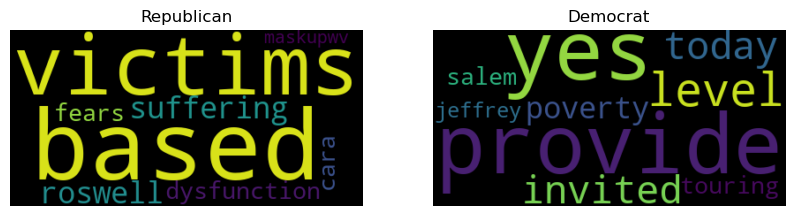

In [15]:
#create wordcloud
# Get the weights of the embedding layer
embedding_weights = model.layers[0].get_weights()[0]

# Correct the indexing error
republican_words = embedding_weights[:, 0].argsort()[:10] + 1  # +1 to align with tokenizer's indexing
democrat_words = embedding_weights[:, 1].argsort()[:10] + 1

# Get the corresponding words from the tokenizer
word_index = tokenizer.word_index

# Get the corresponding words from the tokenizer
republican_words = [word for word, index in word_index.items() if index in republican_words]
democrat_words = [word for word, index in word_index.items() if index in democrat_words]

# Create a word cloud for each class
republican_text = ' '.join(republican_words)
democrat_text = ' '.join(democrat_words)
republican_wordcloud = WordCloud().generate(republican_text)
democrat_wordcloud = WordCloud().generate(democrat_text)

# Plot the word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(republican_wordcloud, interpolation='bilinear')
ax1.set_title('Republican')
ax1.axis('off')
ax2.imshow(democrat_wordcloud, interpolation='bilinear')
ax2.set_title('Democrat')
ax2.axis('off')
plt.show()

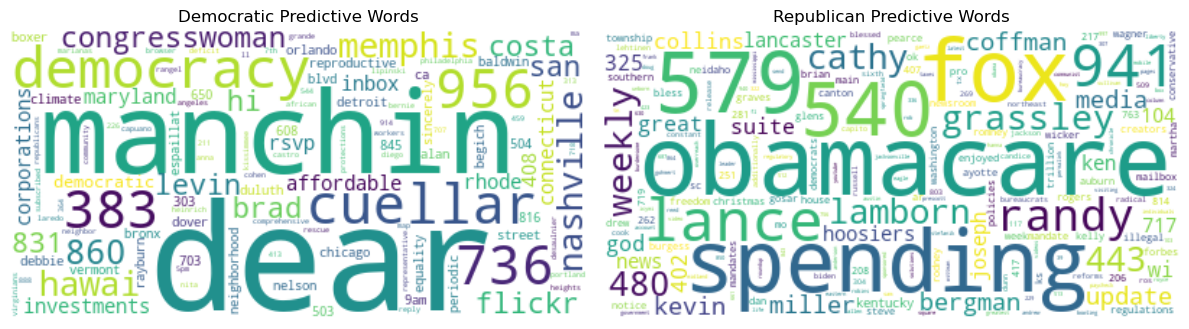

In [9]:
#Another wordcloud approach

# 1. Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_df['Body'])

# 2. Train a logistic regression model
clf = LogisticRegression(max_iter=10000)
y_train = (train_df['Party'] == 'Democrat').astype(int)  # 1 for Democrat, 0 for Republican
clf.fit(X_train, y_train)

# 3. Extract feature importance
# The coefficients in the logistic regression model indicate the importance of each word.
# Positive coefficients are words that predict Democrat, negative coefficients predict Republican.
democratic_word_importances = {word: coef for word, coef in zip(vectorizer.get_feature_names_out(), clf.coef_[0]) if coef > 0}
republican_word_importances = {word: -coef for word, coef in zip(vectorizer.get_feature_names_out(), clf.coef_[0]) if coef < 0}

# 4. Generate word clouds
democratic_wordcloud = WordCloud(background_color="white").generate_from_frequencies(democratic_word_importances)
republican_wordcloud = WordCloud(background_color="white").generate_from_frequencies(republican_word_importances)

# Plot word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(democratic_wordcloud, interpolation='bilinear')
ax1.set_title('Democratic Predictive Words')
ax1.axis('off')
ax2.imshow(republican_wordcloud, interpolation='bilinear')
ax2.set_title('Republican Predictive Words')
ax2.axis('off')
plt.tight_layout()
plt.show()
